
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./kirsch.ipynb" download="kirsch.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=kirsch.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch.py"><img src="https://img.shields.io/static/v1?label=Source:&message=kirsch.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>



In [1]:
import os
from pathlib import Path

import gmsh
import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
from mesh import MeshGenerator

### 1. Release nodal force boundary condition

This boundary condition applies a **time-dependent release nodal force** to nodes on an exposed surface to simulate excavation processes.

The initial state assumes a **non-equilibrium stress** denoted by $\sigma_0$. In the finite element method (FEM), the nodal force is given by:

$$
\mathbf{b} = \int \left( \mathbf{B}^\top (\boldsymbol{\sigma} - \boldsymbol{\sigma}_0) +  \mathbf{N}^\top(\mathbf{f} - \mathbf{f}_0) \right)\, \mathrm{d}\Omega + \int_{\Gamma_q} (\boldsymbol{\sigma}-\boldsymbol{\sigma}_0)\cdot \mathbf n \mathrm{d}\Gamma
$$

Where:
- $\mathbf{B}$ is the strain-displacement matrix,
- $\mathbf{N}$ is the shape function matrix,
- $\boldsymbol{\sigma}$ is the current total stress,
- $\boldsymbol{\sigma}_0$ is the initial total stress,
- $\mathbf{f}$ is the current body force,
- $\mathbf{f}_0$ is the initial body force,
- $\int_{\Gamma_q}$ is the boundary where the traction condition is applied, and $\mathbf n$ is the outward normal of the boundary,
- $N$ is the shape function,
- $\Omega$ is the domain of integration.


After excavation, the stress and body force inside the excavated domain vanish.
This leads to non-zero nodal forces at the **exposed surface nodes**, computed as:

$$
\mathbf{b}_0 = -\int \left( \mathbf{B}^\top \boldsymbol{\sigma}_0 + \mathbf{N}^\top\mathbf{f}_0 \right) \, \mathrm{d}\Omega - \int_{\Gamma_q} \boldsymbol{\sigma}_0\cdot \mathbf n \mathrm{d}\Gamma
$$

The components of $\mathbf{b}_0$ corresponding to the exposed surface nodes define the **release nodal force vector**:

$$
\mathbf{f}_\text{r} := (\mathbf{b}_0)_i, \quad i \in \text{exposed surface nodes}
$$

> Note: If $\Omega$ is the excavated domain, this leads to a negative $\mathbf{f}_\text{r}$.


To simulate gradual excavation, the release nodal force vector is applied to the global right-hand side (RHS) vector $\mathbf{b}$, scaled by a time- and position-dependent release parameter $g(t, \mathbf{x})$:

$$
\mathbf{b} = \mathbf{b} + \mathbf{f}_\text{r} \cdot g(t, \mathbf{x})
$$

##### Parameter requirements:
- Monotonically decreasing: $\frac{\partial g}{\partial t} < 0$
- $g(0, \mathbf{x}) = 1$
- $g(t_e, \mathbf{x}) = 0$, where $t_e$ is the end time of excavation


### 2. Kirsch's problem

Kirsch's problem, a classic example, is used to verify the implementation of the `ReleaseNodalForce` boundary condition.

Kirsch's problem defines an infinite elastic plate with a circular hole of radius $a$ subjected to uniaxial tension or compression stress $\sigma$. If the tension  or the compression is  along y-axis,

<img src="figures/kirsch_figure.png" alt="drawing" width="320"/>

the stress solutions of this problem  in polar coordinates $(r, \theta)$ are given by <a href="#fn1" id="ref1">[1]</a>:

$$
	\begin{align}
		\sigma_r &= \frac{\sigma}{2} \left( 1 - \frac{a^2}{r^2} \right) - \frac{\sigma}{2} \left( 1 - \frac{4a^2}{r^2} + \frac{3a^4}{r^4} \right) \cos 2\theta \\
		\sigma_\theta &= \frac{\sigma}{2} \left( 1 + \frac{a^2}{r^2} \right) + \frac{\sigma}{2} \left( 1 + \frac{3a^4}{r^4} \right) \cos 2\theta  \\
		\tau_{r\theta} &= \frac{\sigma}{2} \left( 1 + \frac{2a^2}{r^2} - \frac{3a^4}{r^4} \right) \sin 2\theta
	\end{align}
$$

- At the hole's boundary $ r = a $: $ \sigma_r = 0 $, $ \tau_{r\theta} = 0 $.
- At $ \theta = 0, \pi $: $ \sigma_\theta = 3\sigma $ (maximum tensile stress).
- At $ \theta = \pm \pi/2 $: $ \sigma_\theta = -\sigma $ (compressive stress).

For the finite element analysis, the geometrical domain is bounded to 140 m $\times$ 140 m with a circular hole of radius 6.5 m located at the domain center. By leveraging the problem's symmetry, we use a quarter of the domain, resulting in the mesh shown below:

<img src="figures/kirsch_mesh.png" alt="drawing" width="320"/>

The problem is analyzed using the release nodal force approach and a standard approach. The initial and boundary conditions for both approaches are provided in the table below:

| Item              | Standard approach | Release Nodal Force  | Unit
| :---------------- | :------------- | :------------- | :-----:|
| Initial stress    |  (0.0, 0.0, 0.0, 0.0) | (0.0, -20.0, 0.0, 0.0) | MPa|
| Bottom    |  $u_y$=0   | $u_y$=0 | m|
| Left    |  $u_x$=0   | $u_x$=0 | m|
| Top    |  $\sigma_y$=-20   |$\sigma_y$=-20, or 0 | MPa|
| Arc    |  Traction $\mathbf\tau=\mathbf 0$   | `ReleaseNodalForce` | N/A|

These conditions result in $\sigma=-20$ MPa and $a=6.5$ m for the analytical solutions.

With the standard approach, the problem is steady-state, requiring only one time step. With the release nodal force approach, the compensation of non equilibrium initial residuum is required, which means the constant traction boundary condition can be ignored. In addition, we assume that the nodal forces at the arc-type boundary are scaled by a linear time-decay factor that varies from 1 to 0 over a period of 2 days. After 2 days, the stress solutions obtained by this approach should be identical to those from the standard approach, and should closely match the analytical solution.

In the subsequent cells, we perform the computations and compare the results against the analytical solutions.

#### Reference
<a id="fn1"></a>[1]: Kirsch, E.G., 1898. Die Theorie der Elastizität und die Bedürfnisse der Festigkeitslehre. Zeitschrift des Vereines Dtsch. Ingenieure 42, 797–807.

In [2]:
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)
mesh_dir = Path(out_dir, "Mesh")

### 3. Mesh generation
#### 3.1. Linear elements

In [3]:
if not gmsh.isInitialized():
    gmsh.initialize()

gmsh.model.add("Mesh")

linear_mesh_dir = Path(mesh_dir, "Linear")
mesh_generator = MeshGenerator(gmsh_model=gmsh.model)
mesh_generator.generate_meshes(out_dir=linear_mesh_dir, order=1)

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 70%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : [100%] Meshing curve 10 (Line)
Info    : Done meshing 1D (Wall 0.00314431s, CPU 0.003417s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 40%] Meshing surface 2 (Plane, Delaunay)
Info    : [ 70%] Meshing surface 3 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.00644584s, CPU 0.005558s)
Info    : 1469 nodes 2051 elements
Info    : Writing '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/Linear/domain.msh'...
Info    : Done writing '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/r

info: Mesh reading time: 0.00301172 s
info: MeshNodeSearcher construction time: 7.4842e-05 s
info: identifySubdomainMesh(): identifySubdomainMeshNodes took 9.2753e-05 s
info: identifySubdomainMesh(): identifySubdomainMeshElements took 0.000687111 s
info: identifySubdomainMesh(): identifySubdomainMeshNodes took 2.29e-06 s
info: There is already a 'bulk_node_ids' property present in the subdomain mesh 'arc' and it is equal to the newly computed values.
info: identifySubdomainMesh(): identifySubdomainMeshElements took 5.2192e-05 s
info: identifySubdomainMesh(): identifySubdomainMeshNodes took 5.05e-06 s
info: There is already a 'bulk_node_ids' property present in the subdomain mesh 'left' and it is equal to the newly computed values.
info: identifySubdomainMesh(): identifySubdomainMeshElements took 5.1592e-05 s
info: identifySubdomainMesh(): identifySubdomainMeshNodes took 5.19e-06 s
info: There is already a 'bulk_node_ids' property present in the subdomain mesh 'bottom' and it is equal t

#### 3.2. Quadratic elements

In [4]:
if not gmsh.isInitialized():
    gmsh.initialize()

gmsh.model.add("Mesh")

mesh_generator = MeshGenerator(gmsh_model=gmsh.model)
mesh_generator.generate_meshes(out_dir=mesh_dir, order=2)

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 70%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : [100%] Meshing curve 10 (Line)
Info    : Done meshing 1D (Wall 0.00396146s, CPU 0.004152s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 40%] Meshing surface 2 (Plane, Delaunay)
Info    : [ 70%] Meshing surface 3 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.00946336s, CPU 0.009394s)
Info    : 1469 nodes 2051 elements
Info    : Writing '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/domain.msh'...
Info    : Done writing '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-

info: Corrected 1674 elements.
info: VTU file written.
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/bottom.vtu
OGS_BIN_PATH:  None .

OGS wheel:  ModuleSpec(name='ogs', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f3766107a70>, origin='/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs/__init__.py', submodule_search_locations=['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs']) .

OGS in PATH:  ['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs', '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs'] .

Please remove OGS from PATH.



info: Create a quadratic order mesh
info: Save the new mesh into a file
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/left.vtu
OGS_BIN_PATH:  None .

OGS wheel:  ModuleSpec(name='ogs', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f3766107a70>, origin='/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs/__init__.py', submodule_search_locations=['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs']) .

OGS in PATH:  ['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs', '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs'] .

Please remove OGS from PATH.

info: Create a quadratic order mesh
info: Save the new mesh into a file
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/rig

info: Create a quadratic order mesh
info: Save the new mesh into a file
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/domain.vtu
OGS_BIN_PATH:  None .

OGS wheel:  ModuleSpec(name='ogs', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f3766107a70>, origin='/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs/__init__.py', submodule_search_locations=['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs']) .

OGS in PATH:  ['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs', '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs'] .

Please remove OGS from PATH.



info: Create a quadratic order mesh
info: Save the new mesh into a file
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/arc.vtu
OGS_BIN_PATH:  None .

OGS wheel:  ModuleSpec(name='ogs', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f3766107a70>, origin='/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs/__init__.py', submodule_search_locations=['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs']) .

OGS in PATH:  ['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs', '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs'] .

Please remove OGS from PATH.

info: Create a quadratic order mesh
info: Save the new mesh into a file
OGS_BIN_PATH:  None .

OGS wheel:  ModuleSpec(name='ogs', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f3766107a70>, origin='/var/

info: writing time: 0.00592273 s
info: Entire run time: 0.0130904 s


#### 4. Computation

In [5]:
def runBenchmark(
    project_file,
    out_dir,
    output_prefix,
    mesh_dir,
    order=2,
    standard_approach=False,
    use_element_deactivation=False,
    ogs_path=None,
):
    prj = ot.Project(
        input_file=project_file,
        output_file=Path(out_dir, f"{output_prefix}.prj"),
        OMP_NUM_THREADS=4,
        OGS_ASM_THREADS=4,
    )

    xpath_var = './process_variables/process_variable[name="displacement"]/'
    prj.replace_text(
        order,
        xpath=xpath_var + "order",
    )

    prj.replace_text(
        output_prefix,
        xpath="./time_loop/output/prefix",
    )

    if standard_approach:
        prj.replace_text(
            "false",
            xpath=xpath_var + "compensate_non_equilibrium_initial_residuum",
        )
        prj.remove_element(
            xpath=xpath_var + 'boundary_conditions/boundary_condition[mesh="arc"]'
        )
        prj.remove_element(xpath="./processes/process/initial_stress")

        prj.remove_element(xpath="./time_loop/processes/process/time_stepping")
        prj.time_loop.set_stepping(
            process="SD",
            type="FixedTimeStepping",
            t_initial="0",
            t_end="1",
            repeat="1",
            delta_t="1.0",
        )

    if use_element_deactivation:
        prj.add_block(
            blocktag="deactivated_subdomains",
            parent_xpath="./process_variables/process_variable",
        )
        prj.add_block(
            blocktag="deactivated_subdomain",
            parent_xpath="./process_variables/process_variable/deactivated_subdomains",
            taglist=["time_interval", "material_ids"],
            textlist=["", "1"],
        )
        prj.add_element(
            parent_xpath="./process_variables/process_variable/deactivated_subdomains/deactivated_subdomain/time_interval",
            tag="start",
            text="0",
        )
        prj.add_element(
            parent_xpath="./process_variables/process_variable/deactivated_subdomains/deactivated_subdomain/time_interval",
            tag="end",
            text="1e+18",
        )

    prj.write_input()

    prj.run_model(
        logfile=Path(out_dir, "log.txt"),
        path=ogs_path,
        args=f"-o {out_dir} -m {mesh_dir}",
    )

    print(f"Output prefix is {output_prefix}")

    return Path(out_dir, f"{output_prefix}.pvd")

##### 4.1. Release nodal force approach

In [6]:
pvd = runBenchmark(
    project_file="kirsch.prj",
    out_dir=out_dir,
    output_prefix="kirsch",
    mesh_dir=mesh_dir,
)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/kirsch.prj
Status: finished successfully.
Execution took 4.341562509536743 s
Output prefix is kirsch


In [7]:
ms = ot.MeshSeries(pvd).scale(time=("s", "d"))
ms_last = ms[-1]
xs = np.asarray(list(np.linspace(6.5, 70.0, 35)))
probes = np.asarray([[i, -857.0, 0] for i in xs])  #  all probes are along the x_axis
extracted_ms = ot.MeshSeries.extract_probe(ms, probes)

In [8]:
pvd_linear = runBenchmark(
    project_file="kirsch.prj",
    out_dir=out_dir,
    output_prefix="kirsch_linear_e",
    mesh_dir=linear_mesh_dir,
    order=1,
)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/kirsch_linear_e.prj
Status: finished successfully.
Execution took 1.0448884963989258 s
Output prefix is kirsch_linear_e


In [9]:
ms_linear = ot.MeshSeries(pvd_linear).scale(time=("s", "d"))
extracted_ms_linear = ot.MeshSeries.extract_probe(ms_linear, probes)

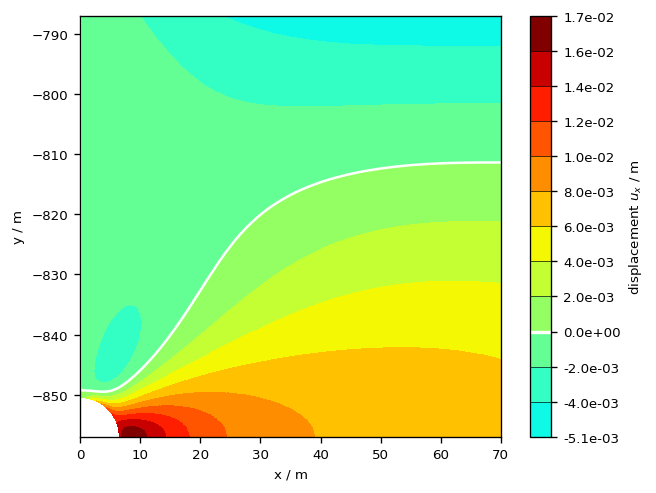

In [10]:
fig = ms_last.plot_contourf(
    ot.variables.displacement["x"],
    figsize=(6, 4),
    fontsize=8,
    cmap="jet",
)

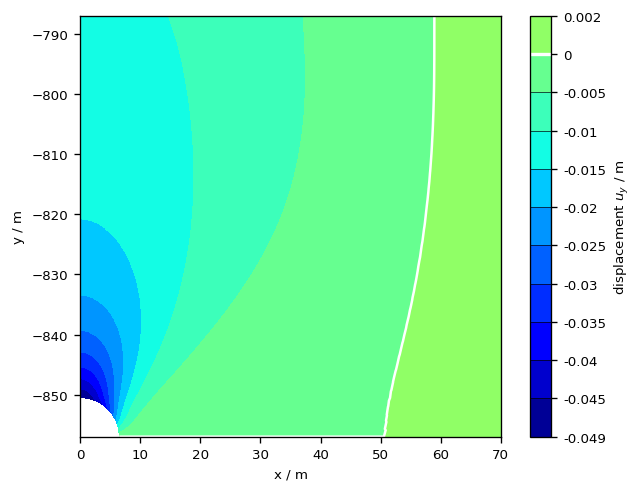

In [11]:
fig = ms_last.plot_contourf(
    ot.variables.displacement["y"], figsize=(6, 4), fontsize=8, cmap="jet"
)

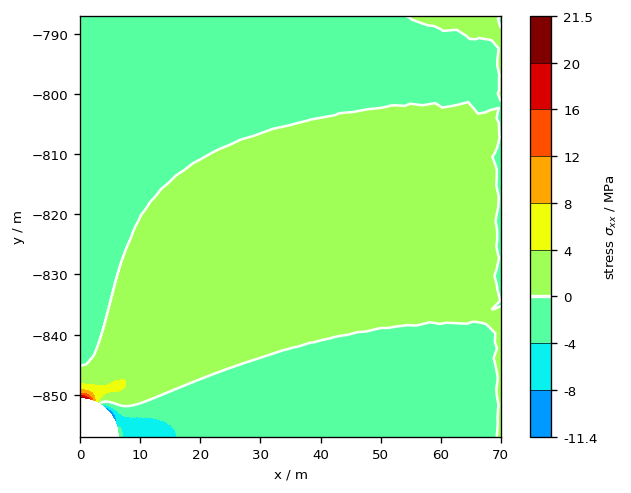

In [12]:
fig = ms_last.plot_contourf(
    ot.variables.stress["xx"], figsize=(6, 4), fontsize=8, cmap="jet"
)

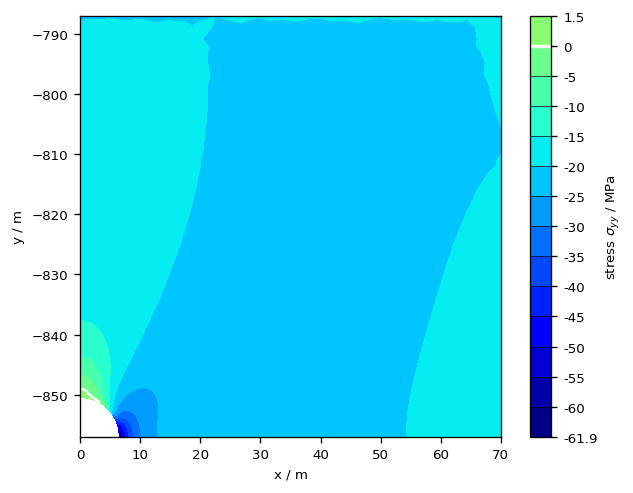

In [13]:
fig = ms_last.plot_contourf(
    ot.variables.stress["yy"], figsize=(6, 4), fontsize=8, cmap="jet"
)

##### 4.2. Standard approach

In [14]:
pvd_std = runBenchmark(
    project_file="kirsch.prj",
    out_dir=out_dir,
    output_prefix="kirsch_standard",
    mesh_dir=mesh_dir,
    order=2,
    standard_approach=True,
)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/kirsch_standard.prj
Status: finished successfully.
Execution took 0.4610023498535156 s
Output prefix is kirsch_standard


In [15]:
ms_std = ot.MeshSeries(pvd_std).scale(time=("s", "d"))
extracted_ms_std = ot.MeshSeries.extract_probe(ms_std, probes)

In [16]:
pvd_std_linear = runBenchmark(
    project_file="kirsch.prj",
    out_dir=out_dir,
    output_prefix="kirsch_standard_linear",
    mesh_dir=linear_mesh_dir,
    order=1,
    standard_approach=True,
)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/kirsch_standard_linear.prj
Status: finished successfully.
Execution took 0.2309112548828125 s
Output prefix is kirsch_standard_linear


In [17]:
ms_std_linear = ot.MeshSeries(pvd_std_linear).scale(time=("s", "d"))
extracted_ms_std_linear = ot.MeshSeries.extract_probe(ms_std_linear, probes)

#### 5. Result comparison

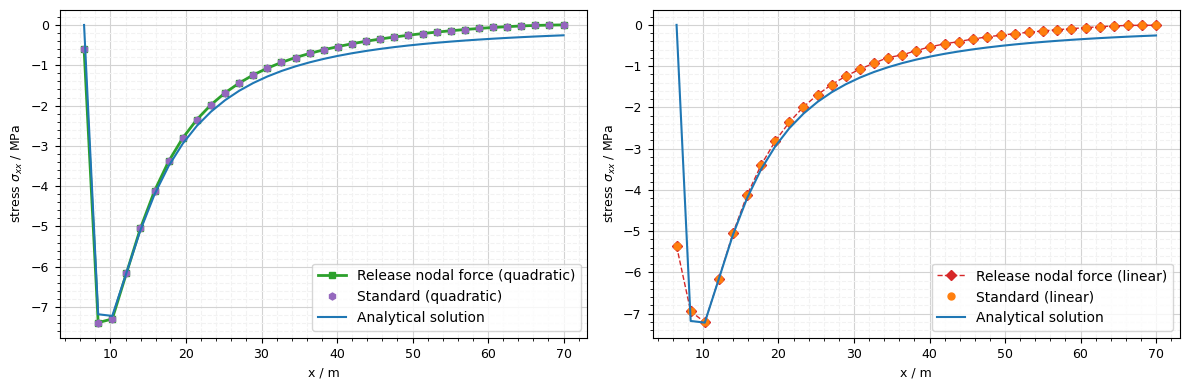

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ot.plot.lineplots.line(
    extracted_ms[-1],
    ot.variables.stress["xx"],
    ax=ax[0],
    fontsize=9,
    linewidth=0.8,
    color="C2",
    marker="s",
    markersize=5,
    label="Release nodal force (quadratic)",
)

ot.plot.lineplots.line(
    extracted_ms_linear[-1],
    ot.variables.stress["xx"],
    ax=ax[1],
    fontsize=9,
    linewidth=0.4,
    linestyle="dashed",
    marker="D",
    markersize=5,
    color="C3",
    label="Release nodal force (linear)",
)

ot.plot.lineplots.line(
    extracted_ms_std[-1],
    ot.variables.stress["xx"],
    ax=ax[0],
    fontsize=9,
    linewidth=0.4,
    marker="h",
    markersize=5,
    color="C4",
    linestyle="None",
    label="Standard (quadratic)",
)

ot.plot.lineplots.line(
    extracted_ms_std_linear[-1],
    ot.variables.stress["xx"],
    ax=ax[1],
    fontsize=9,
    linewidth=0.4,
    marker="o",
    markersize=5,
    color="C1",
    linestyle="None",
    label="Standard (linear)",
)


a = 6.5
sigma_t = -20  # MPa
sigma_x_a = np.asarray(
    [
        0.5 * (3.0 * a * a / (r * r) - 3 * a**4 / (r**4)) * sigma_t
        for r in np.linspace(6.5, 70.0, 35)
    ],
)
ax[0].plot(xs, sigma_x_a, color="C0", label="Analytical solution")
ax[0].legend()
ax[1].plot(xs, sigma_x_a, color="C0", label="Analytical solution")
ax[1].legend()
plt.show()

In the above two figures, the radial stress $\sigma_r$ profiles along the $\theta = 0^\circ$ axis, obtained using the standard approach, the release nodal force approach, and the analytical solution, are compared. The right-hand figure shows results using linear elements, while the left-hand figure displays results using quadratic elements.

At the arc, i.e., $r = 6.5$ m, the stress computed using linear elements shows a significant discrepancy of approximately 5.5 MPa compared to the analytical solution, which is zero. In contrast, the quadratic elements yield highly accurate stress results in the near field, i.e. around $r = 6.5$ m.

In both cases—whether using linear or quadratic elements—the standard approach and the release nodal force approach produce identical stress solutions.

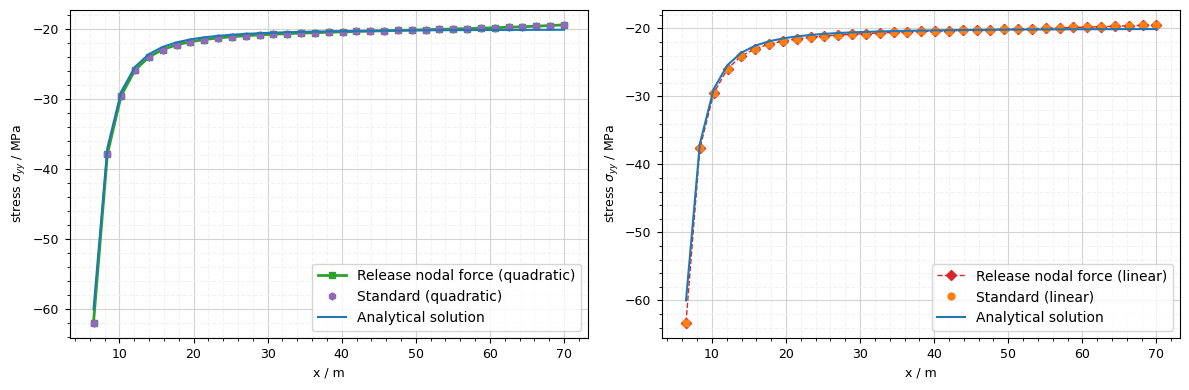

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ot.plot.lineplots.line(
    extracted_ms[-1],
    ot.variables.stress["yy"],
    ax=ax[0],
    fontsize=9,
    linewidth=0.8,
    color="C2",
    marker="s",
    markersize=5,
    label="Release nodal force (quadratic)",
)

ot.plot.lineplots.line(
    extracted_ms_linear[-1],
    ot.variables.stress["yy"],
    ax=ax[1],
    fontsize=9,
    linewidth=0.4,
    linestyle="dashed",
    marker="D",
    markersize=5,
    color="C3",
    label="Release nodal force (linear)",
)

ot.plot.lineplots.line(
    extracted_ms_std[-1],
    ot.variables.stress["yy"],
    ax=ax[0],
    fontsize=9,
    linewidth=0.4,
    marker="h",
    markersize=5,
    color="C4",
    linestyle="None",
    label="Standard (quadratic)",
)

ot.plot.lineplots.line(
    extracted_ms_std_linear[-1],
    ot.variables.stress["yy"],
    ax=ax[1],
    fontsize=9,
    linewidth=0.4,
    marker="o",
    markersize=5,
    color="C1",
    linestyle="None",
    label="Standard (linear)",
)


a = 6.5
sigma_t = -20  # MPa
sigma_y_a = np.asarray(
    [
        0.5 * (2 + a * a / (r * r) + 3 * a**4 / (r**4)) * sigma_t
        for r in np.linspace(6.5, 70.0, 35)
    ],
)
ax[0].plot(xs, sigma_y_a, color="C0", label="Analytical solution")
ax[0].legend()
ax[1].plot(xs, sigma_y_a, color="C0", label="Analytical solution")
ax[1].legend()
plt.show()

In the above two figures, the tangential stress $\sigma_{\theta}$ profiles along the $\theta = 0^\circ$ axis, obtained using the standard approach, the release nodal force approach, and the analytical solution, are compared. The right-hand figure shows results using linear elements, while the left-hand figure displays results using quadratic elements.

In both cases—whether using linear or quadratic elements—the standard approach and the release nodal force approach produce identical stress solutions that match the analytical solution, except at the arc (i.e., $r = 6.5$ m), where the computed stress shows a small, acceptable error.

In [20]:
ys = np.asarray(list(np.linspace(-857 + 6.5, -787.0, 35)))
y_axis = np.asarray([[0, y, 0] for y in ys])
extracted_ms_y = ot.MeshSeries.extract_probe(ms, y_axis)
extracted_ms_y_linear = ot.MeshSeries.extract_probe(ms_linear, y_axis)
extracted_ms_std_y = ot.MeshSeries.extract_probe(ms_std, y_axis)
extracted_ms_std_y_linear = ot.MeshSeries.extract_probe(ms_std_linear, y_axis)

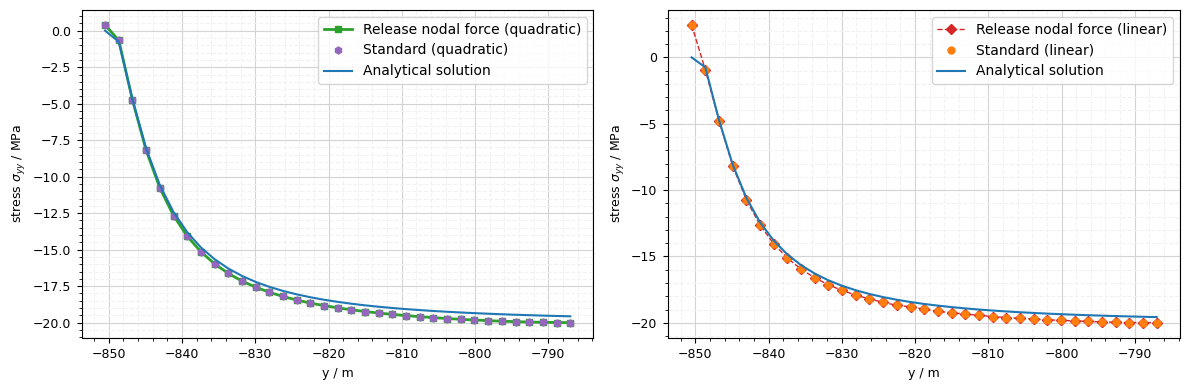

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ot.plot.lineplots.line(
    extracted_ms_y[-1],
    ot.variables.stress["yy"],
    ax=ax[0],
    fontsize=9,
    linewidth=0.8,
    color="C2",
    marker="s",
    markersize=5,
    label="Release nodal force (quadratic)",
)

ot.plot.lineplots.line(
    extracted_ms_y_linear[-1],
    ot.variables.stress["yy"],
    ax=ax[1],
    fontsize=9,
    linewidth=0.4,
    linestyle="dashed",
    marker="D",
    markersize=5,
    color="C3",
    label="Release nodal force (linear)",
)

ot.plot.lineplots.line(
    extracted_ms_std_y[-1],
    ot.variables.stress["yy"],
    ax=ax[0],
    fontsize=9,
    linewidth=0.4,
    marker="h",
    markersize=5,
    color="C4",
    linestyle="None",
    label="Standard (quadratic)",
)

ot.plot.lineplots.line(
    extracted_ms_std_y_linear[-1],
    ot.variables.stress["yy"],
    ax=ax[1],
    fontsize=9,
    linewidth=0.4,
    marker="o",
    markersize=5,
    color="C1",
    linestyle="None",
    label="Standard (linear)",
)


a = 6.5
sigma_t = -20  # MPa
sigma_y_a = np.asarray(
    [
        0.5 * (2.0 - 5.0 * a * a / (r * r) + 3 * a**4 / (r**4)) * sigma_t
        for r in np.linspace(6.5, 70.0, 35)
    ],
)
ax[0].plot(ys, sigma_y_a, color="C0", label="Analytical solution")
ax[0].legend()
ax[1].plot(ys, sigma_y_a, color="C0", label="Analytical solution")
ax[1].legend()
plt.show()

In the two figures above, the radial stress $\sigma_r$ profiles along the $\theta = 90^\circ$ axis are similarly compared across the standard approach, the release nodal force approach, and the analytical solution. The same conclusion as above can be drawn.

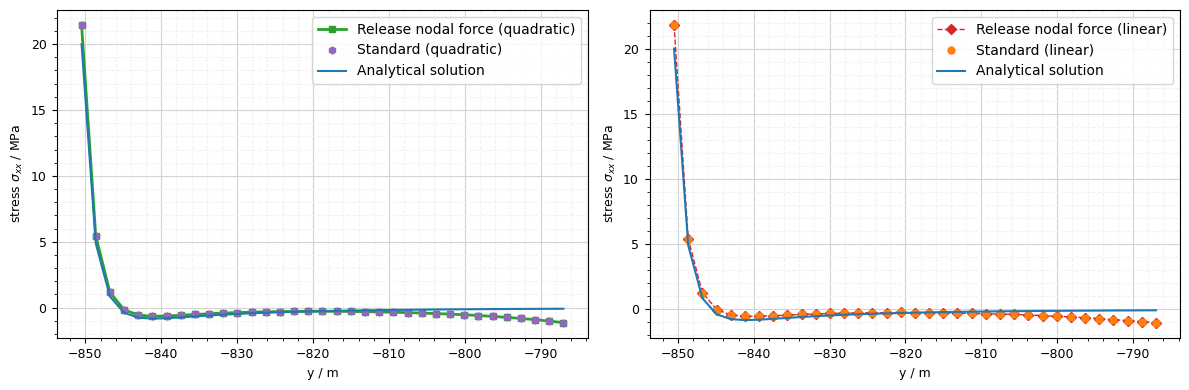

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ot.plot.lineplots.line(
    extracted_ms_y[-1],
    ot.variables.stress["xx"],
    ax=ax[0],
    fontsize=9,
    linewidth=0.8,
    color="C2",
    marker="s",
    markersize=5,
    label="Release nodal force (quadratic)",
)

ot.plot.lineplots.line(
    extracted_ms_y_linear[-1],
    ot.variables.stress["xx"],
    ax=ax[1],
    fontsize=9,
    linewidth=0.4,
    linestyle="dashed",
    marker="D",
    markersize=5,
    color="C3",
    label="Release nodal force (linear)",
)

ot.plot.lineplots.line(
    extracted_ms_std_y[-1],
    ot.variables.stress["xx"],
    ax=ax[0],
    fontsize=9,
    linewidth=0.4,
    marker="h",
    markersize=5,
    color="C4",
    linestyle="None",
    label="Standard (quadratic)",
)

ot.plot.lineplots.line(
    extracted_ms_std_y_linear[-1],
    ot.variables.stress["xx"],
    ax=ax[1],
    fontsize=9,
    linewidth=0.4,
    marker="o",
    markersize=5,
    color="C1",
    linestyle="None",
    label="Standard (linear)",
)


a = 6.5
sigma_t = -20  # MPa
sigma_x_a = np.asarray(
    [
        0.5 * (a * a / (r * r) - 3.0 * (a**4) / (r**4)) * sigma_t
        for r in np.linspace(6.5, 70.0, 35)
    ],
)
ax[0].plot(ys, sigma_x_a, color="C0", label="Analytical solution")
ax[0].legend()
ax[1].plot(ys, sigma_x_a, color="C0", label="Analytical solution")
ax[1].legend()
plt.show()

In the two figures above, the tangential stress $\sigma_{\theta}$ profiles along the $\theta = 90^\circ$ axis—obtained using the standard approach, the release nodal force approach, and the analytical solution—are compared. The figure on the right shows results using linear elements, while the figure on the left displays results using quadratic elements.

The figures show that the quadratic elements deliver more accurate tangential stress results than the linear elements do.

In [23]:
expected_sigma = np.asarray(
    [
        [-5.94322287e05, -6.19135039e07, -1.27523478e07, 2.88857973e04],
        [-7.38612284e06, -3.78634237e07, -7.57486395e06, -2.74920238e03],
        [-7.29498760e06, -2.94823378e07, -5.03319762e06, -3.27663485e03],
        [-6.16488594e06, -2.58398957e07, -3.60143449e06, -2.60637616e03],
        [-5.04277461e06, -2.39769644e07, -2.70592169e06, -2.07279666e03],
        [-4.11466919e06, -2.29094598e07, -2.10723869e06, -1.69815834e03],
        [-3.38126432e06, -2.22451952e07, -1.68793785e06, -1.40729000e03],
        [-2.80371628e06, -2.18014961e07, -1.38156370e06, -1.17465349e03],
        [-2.34615469e06, -2.14891135e07, -1.15058044e06, -9.98750305e02],
        [-1.97963051e06, -2.12583248e07, -9.71386582e05, -8.60535012e02],
        [-1.68324892e06, -2.10813427e07, -8.29377479e05, -7.45988821e02],
        [-1.44071102e06, -2.09408077e07, -7.14455626e05, -6.50120818e02],
        [-1.23965749e06, -2.08255722e07, -6.19568905e05, -5.72627005e02],
        [-1.07127244e06, -2.07285029e07, -5.39932597e05, -5.12683328e02],
        [-9.28899184e05, -2.06446594e07, -4.72067578e05, -4.45982983e02],
        [-8.07521486e05, -2.05705571e07, -4.13423564e05, -2.21726184e02],
        [-7.05979106e05, -2.05109383e07, -3.65075218e05, -3.15018646e02],
        [-6.15691161e05, -2.04493251e07, -3.19504872e05, -2.65589391e02],
        [-5.36410677e05, -2.03910163e07, -2.78228085e05, -1.95228720e02],
        [-4.65745754e05, -2.03367742e07, -2.40755986e05, 3.60608473e00],
        [-4.03763440e05, -2.02836893e07, -2.06235823e05, -3.31921648e01],
        [-3.48404405e05, -2.02325609e07, -1.74289580e05, 7.66657794e01],
        [-2.98877382e05, -2.01825157e07, -1.44417936e05, 1.10241632e02],
        [-2.54347664e05, -2.01322911e07, -1.15991634e05, -4.93793966e02],
        [-2.13145348e05, -2.00815642e07, -8.84128639e04, -2.88508731e02],
        [-1.76885709e05, -2.00300224e07, -6.20724270e04, 6.39934952e02],
        [-1.43619900e05, -1.99764731e07, -3.60279032e04, -1.06828469e02],
        [-1.13392504e05, -1.99204980e07, -1.01671562e04, -5.46904858e02],
        [-8.63626204e04, -1.98615646e07, 1.56218327e04, -4.55060897e02],
        [-6.23428362e04, -1.97990850e07, 4.15716366e04, -3.40173118e02],
        [-4.20200786e04, -1.97309295e07, 6.81151364e04, -1.84318790e02],
        [-2.46657663e04, -1.96579937e07, 9.52021698e04, 1.43594104e02],
        [-1.14482194e04, -1.95785854e07, 1.22989929e05, 5.02062221e02],
        [-3.39460636e03, -1.94873291e07, 1.52782881e05, 1.02289311e03],
        [2.04509604e03, -1.93933612e07, 1.82605155e05, 2.68937637e03],
    ]
)


computed_sigma = extracted_ms[-1]["sigma"]

np.testing.assert_allclose(actual=computed_sigma, desired=expected_sigma, atol=1e-10)

In [24]:
sigma_at_step_1 = extracted_ms[1]["sigma"]
sigma_at_step_1_expected = np.asarray(
    [
        [-3.43936509e04, -2.24255500e07, -7.37983093e05, 1.67163179e03],
        [-4.27437665e05, -2.10337629e07, -4.38360182e05, -1.59097360e02],
        [-4.22163634e05, -2.05487464e07, -2.91273010e05, -1.89620073e02],
        [-3.56764233e05, -2.03379569e07, -2.08416348e05, -1.50831953e02],
        [-2.91827234e05, -2.02301484e07, -1.56592690e05, -1.19953510e02],
        [-2.38117430e05, -2.01683715e07, -1.21946683e05, -9.82730522e01],
        [-1.95675018e05, -2.01299303e07, -9.76815885e04, -8.14403934e01],
        [-1.62252100e05, -2.01042532e07, -7.99516032e04, -6.79776323e01],
        [-1.35772841e05, -2.00861755e07, -6.65845164e04, -5.77980501e01],
        [-1.14561951e05, -2.00728197e07, -5.62145013e04, -4.97994799e01],
        [-9.74102387e04, -2.00625777e07, -4.79963819e04, -4.31706493e01],
        [-8.33744801e04, -2.00544449e07, -4.13458117e04, -3.76227325e01],
        [-7.17394380e04, -2.00477762e07, -3.58546820e04, -3.31381369e01],
        [-6.19949331e04, -2.00421587e07, -3.12460994e04, -2.96691741e01],
        [-5.37557398e04, -2.00373067e07, -2.73187256e04, -2.58092004e01],
        [-4.67315675e04, -2.00330183e07, -2.39249747e04, -1.28313764e01],
        [-4.08552723e04, -2.00295682e07, -2.11270381e04, -1.82302457e01],
        [-3.56302755e04, -2.00260026e07, -1.84898653e04, -1.53697564e01],
        [-3.10422845e04, -2.00226283e07, -1.61011623e04, -1.12979583e01],
        [-2.69528793e04, -2.00194892e07, -1.39326381e04, 2.08685460e-01],
        [-2.33659398e04, -2.00164172e07, -1.19349435e04, -1.92084287e00],
        [-2.01622920e04, -2.00134584e07, -1.00862026e04, 4.43667705e00],
        [-1.72961448e04, -2.00105623e07, -8.35751946e03, 6.37972409e00],
        [-1.47191935e04, -2.00076557e07, -6.71247881e03, -2.85760397e01],
        [-1.23348002e04, -2.00047202e07, -5.11648518e03, -1.66961071e01],
        [-1.02364415e04, -2.00017374e07, -3.59215434e03, 3.70332727e01],
        [-8.31133678e03, -1.99986385e07, -2.08494810e03, -6.18220306e00],
        [-6.56206620e03, -1.99953992e07, -5.88377097e02, -3.16495867e01],
        [-4.99783683e03, -1.99919887e07, 9.04041242e02, -2.63345427e01],
        [-3.60780302e03, -1.99883730e07, 2.40576601e03, -1.96859443e01],
        [-2.43171751e03, -1.99844288e07, 3.94184817e03, -1.06665966e01],
        [-1.42741703e03, -1.99802080e07, 5.50938483e03, 8.30984396e00],
        [-6.62512697e02, -1.99756126e07, 7.11747273e03, 2.90545267e01],
        [-1.96447127e02, -1.99703315e07, 8.84160191e03, 5.91952033e01],
        [1.18350465e02, -1.99648936e07, 1.05674280e04, 1.55635206e02],
    ]
)

np.testing.assert_allclose(
    actual=sigma_at_step_1, desired=sigma_at_step_1_expected, atol=1e-10
)

In [25]:
r = 6.5
h = -857
spoints = np.asarray(
    [
        [0, h + y, 0]
        for y in [
            r,
            r + 1,
            r + 2.5,
            r + 3.5,
            r + 8.5,
        ]
    ]
)
labels = [f"r = {point[1] -h:.1f} m" for i, point in enumerate(spoints)]

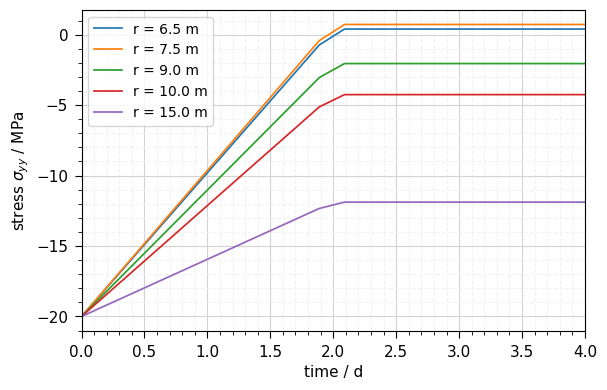

In [26]:
extracted_sp = ot.MeshSeries.extract_probe(ms, spoints)
ot.plot.line(
    extracted_sp,
    "time",
    ot.variables.stress["yy"],
    labels=labels,
    figsize=(6, 4),
    fontsize=11,
    linewidth=0.5,
)
plt.xlim(0, 4)
plt.legend()

plt.grid(True)
plt.show()

The figure above shows the radial stress variation at different positions along the $\theta = 0^\circ$ axis.

Over time, the absolute stress values decrease from their initial value of 20 MPa, especially at the boundary ($r = 6.5\,\text{m}$), where the stress drops to nearly the expected value of zero.

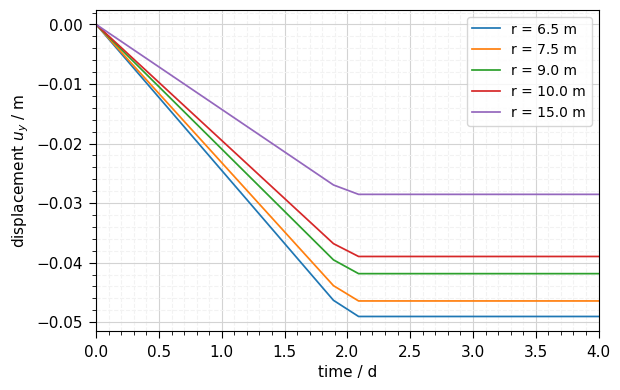

In [27]:
ot.plot.line(
    extracted_sp,
    "time",
    ot.variables.displacement["y"],
    labels=labels,
    figsize=(6, 4),
    fontsize=11,
    linewidth=0.5,
)
plt.xlim(0, 4)
plt.legend()

plt.grid(True)
plt.show()

The figure above shows the radial displacement variation at different positions along the $\theta = 0^\circ$ axis.

Over time, the absolute displacement values increase, particularly at the boundary ($r = 6.5\,\text{m}$), where the maximum displacement change occurs as expected.

#### 6. Simulation using element deactivation

For comparison, we also simulate the same problem using element deactivation.
In this case, the domain includes the hole, and the elements inside the hole are deactivated throughout the entire simulation. The stress values at their integration points of the deactivated elements are set to zero to ensure accurate extrapolation.

In [28]:
if not gmsh.isInitialized():
    gmsh.initialize()

gmsh.model.add("Mesh")

mesh_generator = MeshGenerator(gmsh_model=gmsh.model)
mesh_dir_with_hole = Path(out_dir, "Mesh", "Entire")
mesh_generator.generate_meshes(out_dir=mesh_dir_with_hole, with_cavern=True, order=2)

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 70%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : [100%] Meshing curve 10 (Line)
Info    : Done meshing 1D (Wall 0.00317584s, CPU 0.003365s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 40%] Meshing surface 2 (Plane, Delaunay)
Info    : [ 70%] Meshing surface 3 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.00646224s, CPU 0.006453s)
Info    : 1469 nodes 2051 elements
Info    : Writing '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/Entire/domain.msh'...
Info    : Done writing '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/r

info: Create a quadratic order mesh
info: Save the new mesh into a file
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/Entire/domain.vtu
OGS_BIN_PATH:  None .

OGS wheel:  ModuleSpec(name='ogs', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f3766107a70>, origin='/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs/__init__.py', submodule_search_locations=['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs']) .

OGS in PATH:  ['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs', '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs'] .

Please remove OGS from PATH.

info: Create a quadratic order mesh
info: Save the new mesh into a file
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch

info: Create a quadratic order mesh
info: Save the new mesh into a file
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/Mesh/Entire/bottom.vtu
OGS_BIN_PATH:  None .

OGS wheel:  ModuleSpec(name='ogs', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f3766107a70>, origin='/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs/__init__.py', submodule_search_locations=['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/site-packages/ogs']) .

OGS in PATH:  ['/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs', '/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/bin/ogs'] .

Please remove OGS from PATH.

info: Create a quadratic order mesh
info: Save the new mesh into a file
Create quadratic mesh for /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch

info: Entire run time: 0.0149732 s


In [29]:
pvd_ed = runBenchmark(
    project_file="kirsch.prj",
    out_dir=out_dir,
    output_prefix="kirsch_element_deactivation",
    mesh_dir=mesh_dir_with_hole,
    order=2,
    use_element_deactivation=True,
)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Mechanics/ReleaseNodalForceKirsch/kirsch/kirsch_element_deactivation.prj
Status: finished successfully.
Execution took 4.381377935409546 s
Output prefix is kirsch_element_deactivation


In [30]:
ms_ed = ot.MeshSeries(pvd_ed).scale(time=("s", "d"))

extracted_ms_ed_x = ot.MeshSeries.extract_probe(ms_ed, probes)
extracted_ms_ed_y = ot.MeshSeries.extract_probe(ms_ed, y_axis)

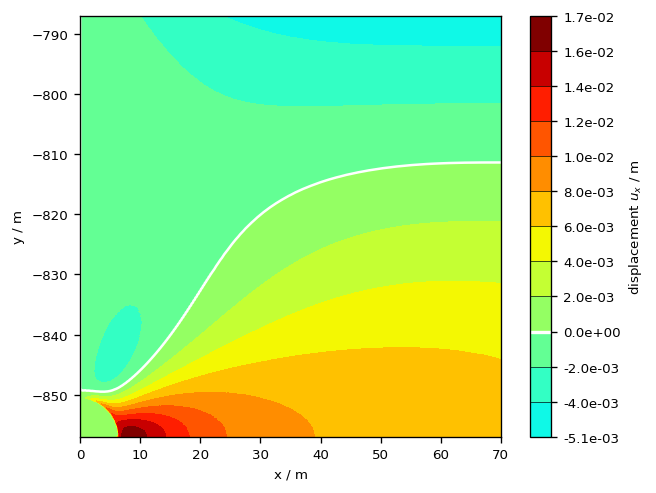

In [31]:
fig = ms_ed[-1].plot_contourf(
    ot.variables.displacement["x"],
    figsize=(6, 4),
    fontsize=8,
    cmap="jet",
)

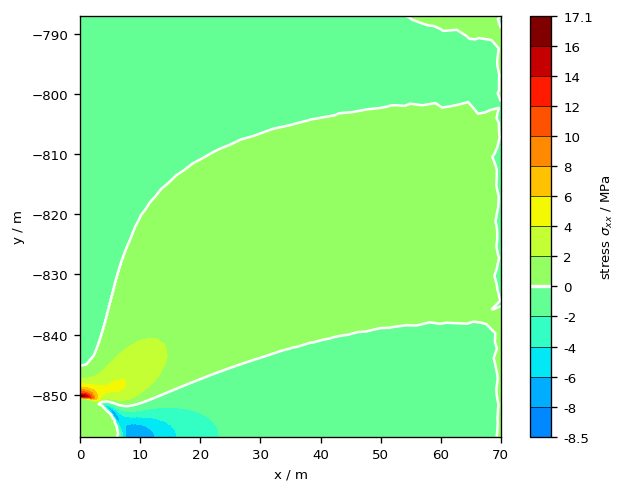

In [32]:
fig = ms_ed[-1].plot_contourf(
    ot.variables.stress["xx"],
    figsize=(6, 4),
    fontsize=8,
    cmap="jet",
)

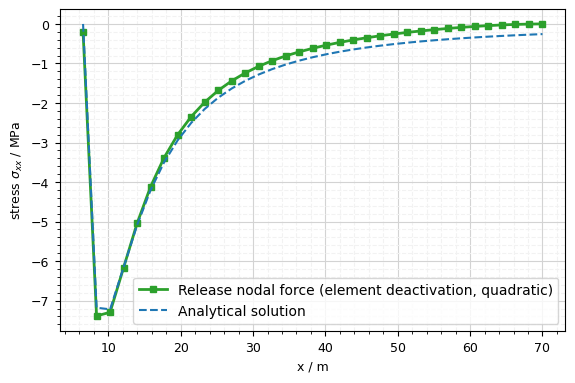

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ot.plot.lineplots.line(
    extracted_ms_ed_x[-1],
    ot.variables.stress["xx"],
    ax=ax,
    fontsize=9,
    linewidth=0.8,
    color="C2",
    marker="s",
    markersize=5,
    label="Release nodal force (element deactivation, quadratic)",
)

a = 6.5
sigma_t = -20  # MPa
sigma_x_a = np.asarray(
    [
        0.5 * (3.0 * a * a / (r * r) - 3 * a**4 / (r**4)) * sigma_t
        for r in np.linspace(6.5, 70.0, 35)
    ],
)
plt.plot(xs, sigma_x_a, color="C0", label="Analytical solution")
plt.legend()
plt.show()

In the above figure, the radial stress $\sigma_r$ profiles along the $\theta = 0^\circ$ axis, obtained using the release nodal force approach together with the element deactivation and the analytical solution, are compared.

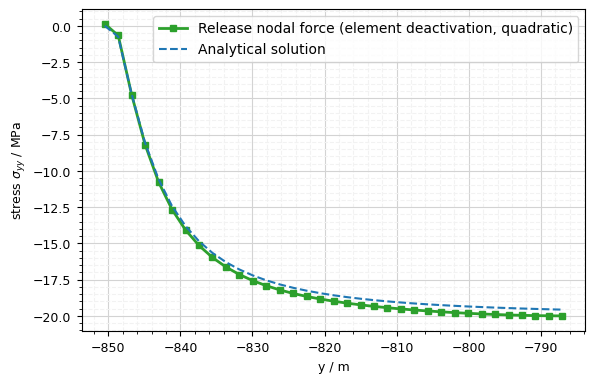

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ot.plot.lineplots.line(
    extracted_ms_ed_y[-1],
    ot.variables.stress["yy"],
    ax=ax,
    fontsize=9,
    linewidth=0.8,
    color="C2",
    marker="s",
    markersize=5,
    label="Release nodal force (element deactivation, quadratic)",
)

a = 6.5
sigma_t = -20  # MPa
sigma_y_a = np.asarray(
    [
        0.5 * (2.0 - 5.0 * a * a / (r * r) + 3 * a**4 / (r**4)) * sigma_t
        for r in np.linspace(6.5, 70.0, 35)
    ],
)
plt.plot(ys, sigma_y_a, color="C0", label="Analytical solution")
plt.legend()
plt.show()

In the above figure, the radial stress $\sigma_r$ profiles along the $\theta = 90^\circ$ axis, obtained using the release nodal force approach together with the element deactivation and the analytical solution, are compared.

#### 7. Conclusions

The implemented `ReleaseNodalForce` type boundary condition is verified using the classic example of Kirsch's problem.

Verification is carried out by analyzing Kirsch's problem using both the release nodal force approach and the standard approach. By comparing the solutions obtained from the standard approach and the analytical solution, the correctness of the present method and its implementation is validated.
In the near field, the numerical method yields highly accurate stress results.

In the far field, the numerical results show a small, acceptable error compared to the analytical solution, which is for an ideal model with an infinite domain.

This boundary condition can be used together with the element deactivation approach. In this case, the stress values in the deactivated element must be set to zero to ensure accurate stress extrapolation.

Additionally, the benchmark is evaluated using linear elements, which result in significant stress errors due extrapolation. Therefore, linear elements should be avoided in stress analyses to ensure accurate results.